### 목차

1. 데이터 요약 및 가설
2. 가설 검정
3. train / test 세트 분리 및 클래스 불균형 해소
4. StratifiedKFold와 앙상블을 이용한 예측 및 성능 평가

### 1. 데이터 요약 및 가설

#### 1.1 데이터 요약 

- 'gender', 'SeniorCitizen', 'Partner', 'Dependents' : 가입자의 인구 통계학적 특성을 나타냄. '성별', '노인 여부', '배우자 유무', '부양가족 유무'를 의미

- 'tenure' : 가입 기간

- 'MultipleLines' : 다중 회선 사용 여부. 'PhoneService'가 'No'인 경우 'No phone service'라고 기재됨.

- 'InternetService' : 'DSL', 'Fiber optic', 'No'. DSL은 기존 전화선을 사용하며 가격이 저렴한 대신 속도가 다소 느림. Fiber optic은 광섬유 케이블을 사용하며 DSL에 비해 상대적으로 가격이 비싸나 속도가 빠르고 안정적임.

- 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' : 'InternetService'를 사용하는 고객이 이용하는 서비스

- 'Contract' : 'Month-to-month', 'One year', 'Two year' 가입 시 계약 유형

- 'PaymentMethod' : 지불 수단을 나타내며 'Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check' 값을 가짐. 'PaperlessBilling' 컬럼 값이 'No'인 경우 'Mailed check'을 이용함.

- 'MonthlyCharges' : 월 요금

- 'TotalCharges' : 가입 기간 동안 총 요금

- 'Churn' : 이탈 여부

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('/home/dev-hammy/pj/tele-churn/Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
columns_to_check = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaymentMethod'
]

for col in columns_to_check:
    print(f"Column: {col}")
    print(df[col].value_counts().sort_index())
    print("-" * 40)


Column: MultipleLines
MultipleLines
No                  3390
No phone service     682
Yes                 2971
Name: count, dtype: int64
----------------------------------------
Column: InternetService
InternetService
DSL            2421
Fiber optic    3096
No             1526
Name: count, dtype: int64
----------------------------------------
Column: OnlineSecurity
OnlineSecurity
No                     3498
No internet service    1526
Yes                    2019
Name: count, dtype: int64
----------------------------------------
Column: OnlineBackup
OnlineBackup
No                     3088
No internet service    1526
Yes                    2429
Name: count, dtype: int64
----------------------------------------
Column: DeviceProtection
DeviceProtection
No                     3095
No internet service    1526
Yes                    2422
Name: count, dtype: int64
----------------------------------------
Column: TechSupport
TechSupport
No                     3473
No internet service    1526


In [4]:
df['gender'] = df['gender'].apply(lambda x : 1 if x == 'Male' else 0)

cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn']

for col in cols :
    df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)

df = df.drop(['customerID', 'PaperlessBilling', 'TotalCharges'], axis=1)

In [5]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,Electronic check,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,Mailed check,56.95,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,Mailed check,53.85,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,Bank transfer (automatic),42.30,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,Electronic check,70.70,1


#### 1.2 고객 세분화

- 'tenure' : 가입 기간(월)을 나타내는 연속형 변수를 연 단위로 나누어서 그룹화('Tenure')하여 관찰

- 'MonthlyCharges', 'Contract' : 계약 유형 및 조건(가입 서비스)에 따라 월 이용 요금이 다를 것이다. 각 계약 유형의 'MonthlyCharges' 분포를 살피고, 공통된 개수의 구간(범위는 각자 다름)으로 소비자 그룹('CustomerLevel')을 나누어본다.

- 'Churn' : 이탈 그룹과 유지 그룹 

In [6]:
service_columns = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

In [7]:
people_columns = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents'
]

In [8]:
def assign_tenure(row) :
    if row['tenure'] == 0 :
        return 0
    elif row['tenure'] > 0 and row['tenure'] <= 12 :
        return 1
    elif row['tenure'] > 12 and row['tenure'] <= 24 :
        return 2
    elif row['tenure'] > 24 and row['tenure'] <= 36 :
        return 3
    elif row['tenure'] > 36 and row['tenure'] <= 48 :
        return 4
    elif row['tenure'] > 48 and row['tenure'] <= 60 :
        return 5
    else :
        return 6
    
df['Tenure'] = df.apply(assign_tenure, axis=1)
df = df.drop(['tenure'], axis=1)
# 결과 확인
print(df['Tenure'].value_counts(dropna=False))

Tenure
1    2175
6    1407
2    1024
5     832
3     832
4     762
0      11
Name: count, dtype: int64


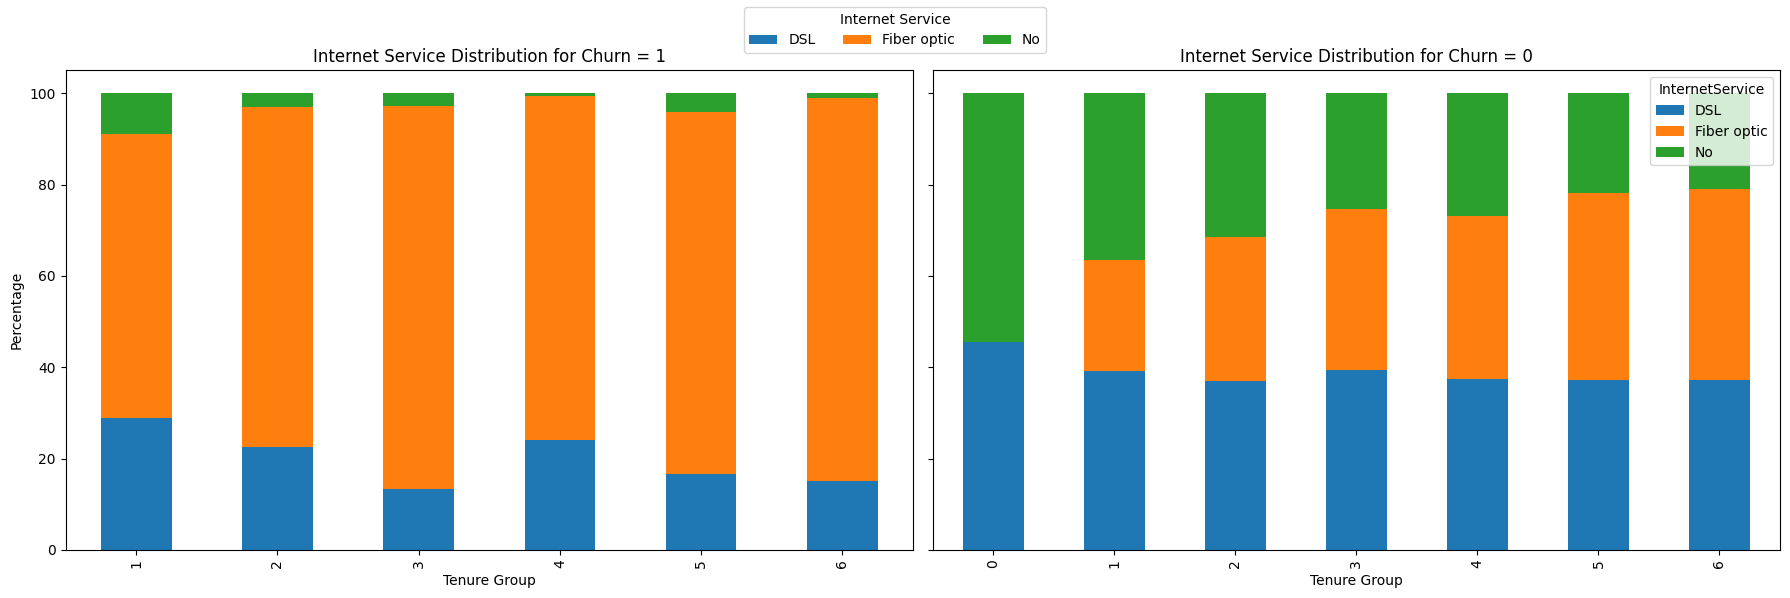

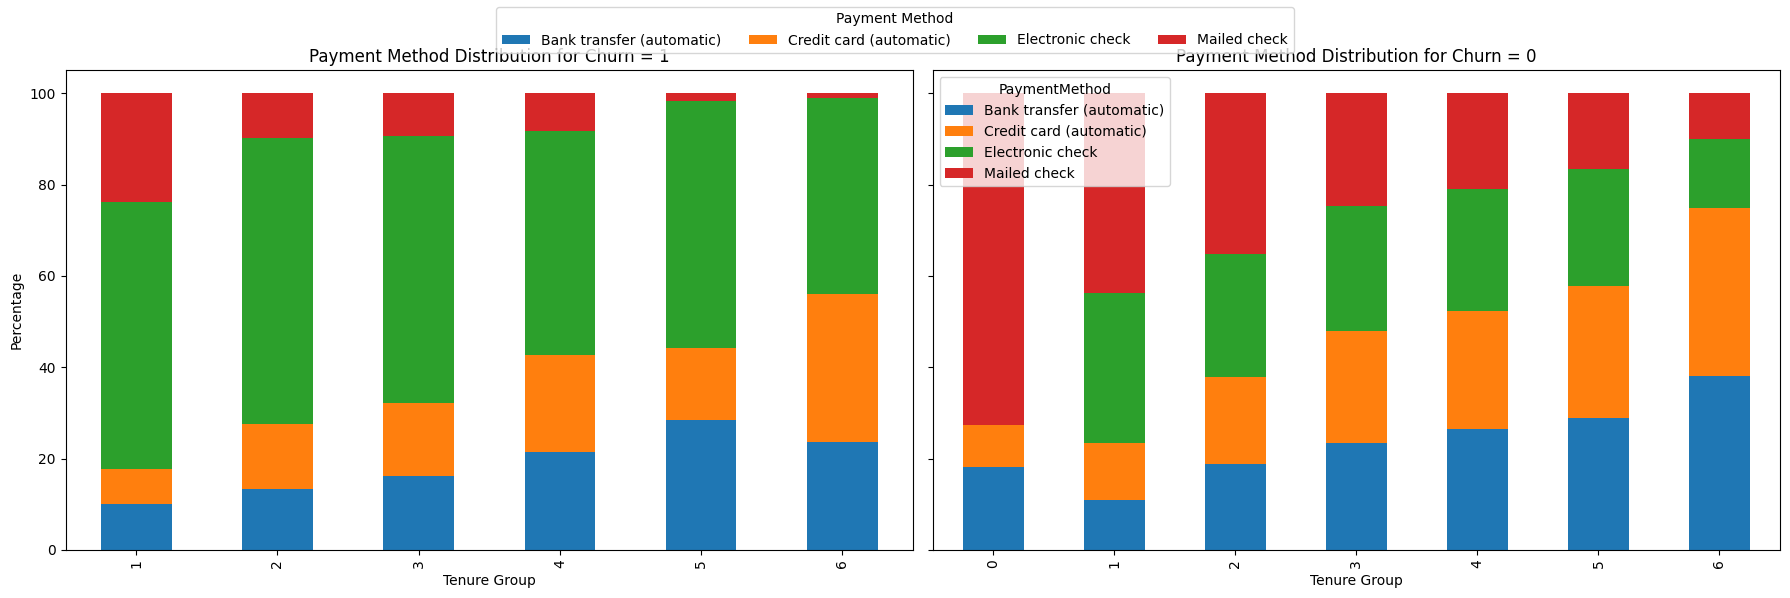

In [9]:
# Subplot-based visualization function for general columns
def plot_side_by_side_all(out_percentage, in_percentage, title_out, title_in, legend_title):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    
    # Out data
    out_percentage.plot(kind='bar', stacked=True, ax=axes[0], legend=False)
    axes[0].set_title(title_out)
    axes[0].set_xlabel('Tenure Group')
    axes[0].set_ylabel('Percentage')
    
    # In data
    in_percentage.plot(kind='bar', stacked=True, ax=axes[1], legend=True)
    axes[1].set_title(title_in)
    axes[1].set_xlabel('Tenure Group')
    
    # Adjust legends
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(labels), title=legend_title)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# (1) Internet Service
internet_out_debug = df[df['Churn'] == 1].groupby(['Tenure', 'InternetService']).size().unstack(fill_value=0)
internet_in_debug = df[df['Churn'] == 0].groupby(['Tenure', 'InternetService']).size().unstack(fill_value=0)
internet_out_percentage = internet_out_debug.div(internet_out_debug.sum(axis=1), axis=0).fillna(0) * 100
internet_in_percentage = internet_in_debug.div(internet_in_debug.sum(axis=1), axis=0).fillna(0) * 100

plot_side_by_side_all(
    internet_out_percentage, internet_in_percentage,
    "Internet Service Distribution for Churn = 1",
    "Internet Service Distribution for Churn = 0",
    "Internet Service"
)

# (2) Payment Method
payment_out_debug = df[df['Churn'] == 1].groupby(['Tenure', 'PaymentMethod']).size().unstack(fill_value=0)
payment_in_debug = df[df['Churn'] == 0].groupby(['Tenure', 'PaymentMethod']).size().unstack(fill_value=0)
payment_out_percentage = payment_out_debug.div(payment_out_debug.sum(axis=1), axis=0).fillna(0) * 100
payment_in_percentage = payment_in_debug.div(payment_in_debug.sum(axis=1), axis=0).fillna(0) * 100

plot_side_by_side_all(
    payment_out_percentage, payment_in_percentage,
    "Payment Method Distribution for Churn = 1",
    "Payment Method Distribution for Churn = 0",
    "Payment Method"
)


#### (1-1) Tenure 그룹화 시사점

- 이탈 그룹(Churn=1)은 DSL보다 신식이고 속도가 강점인 Fiber optic 서비스 사용자가 많고, Electrnonic check 결제를 사용하는 비중이 높으며 Mailed check 서비스를 이용하는 비중이 낮았다. 디지털 문화에 익숙한 사용자 집단으로 보인다.

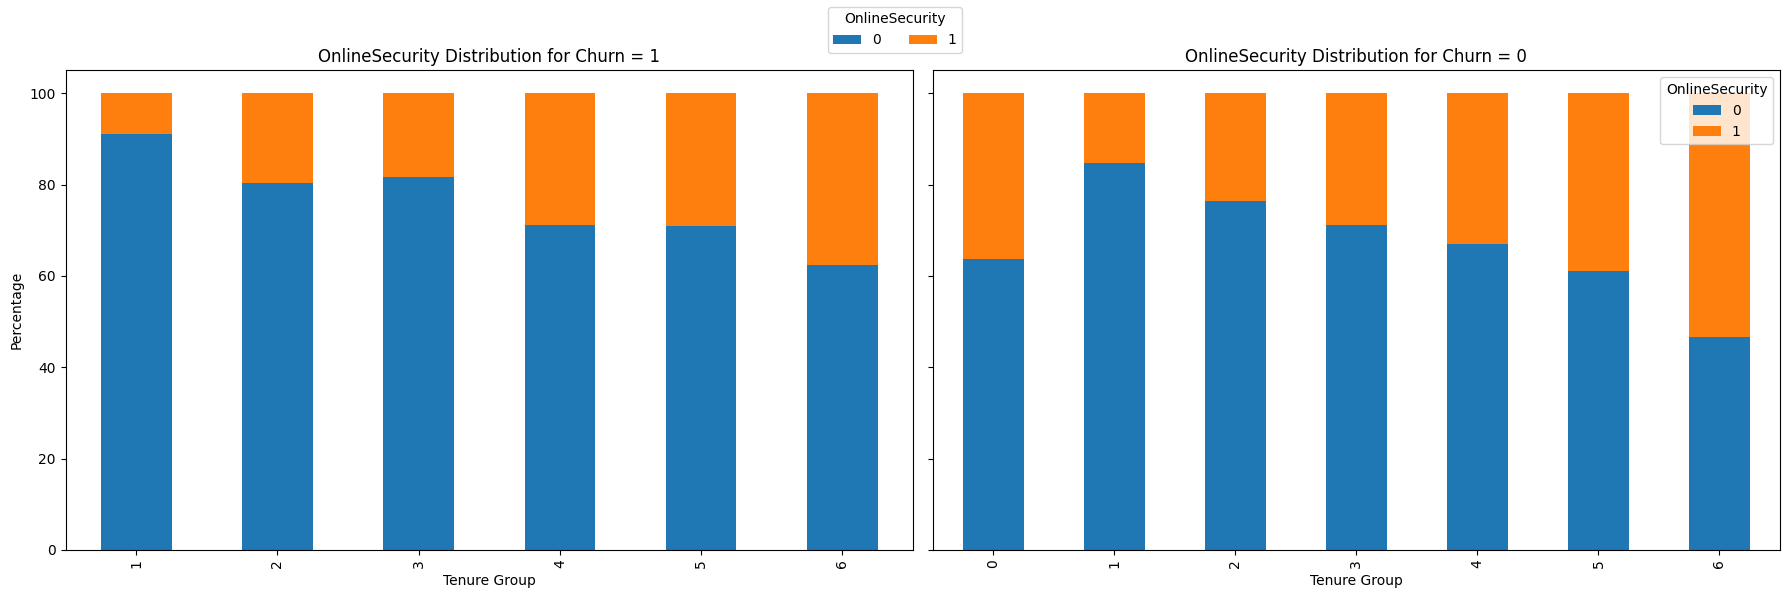

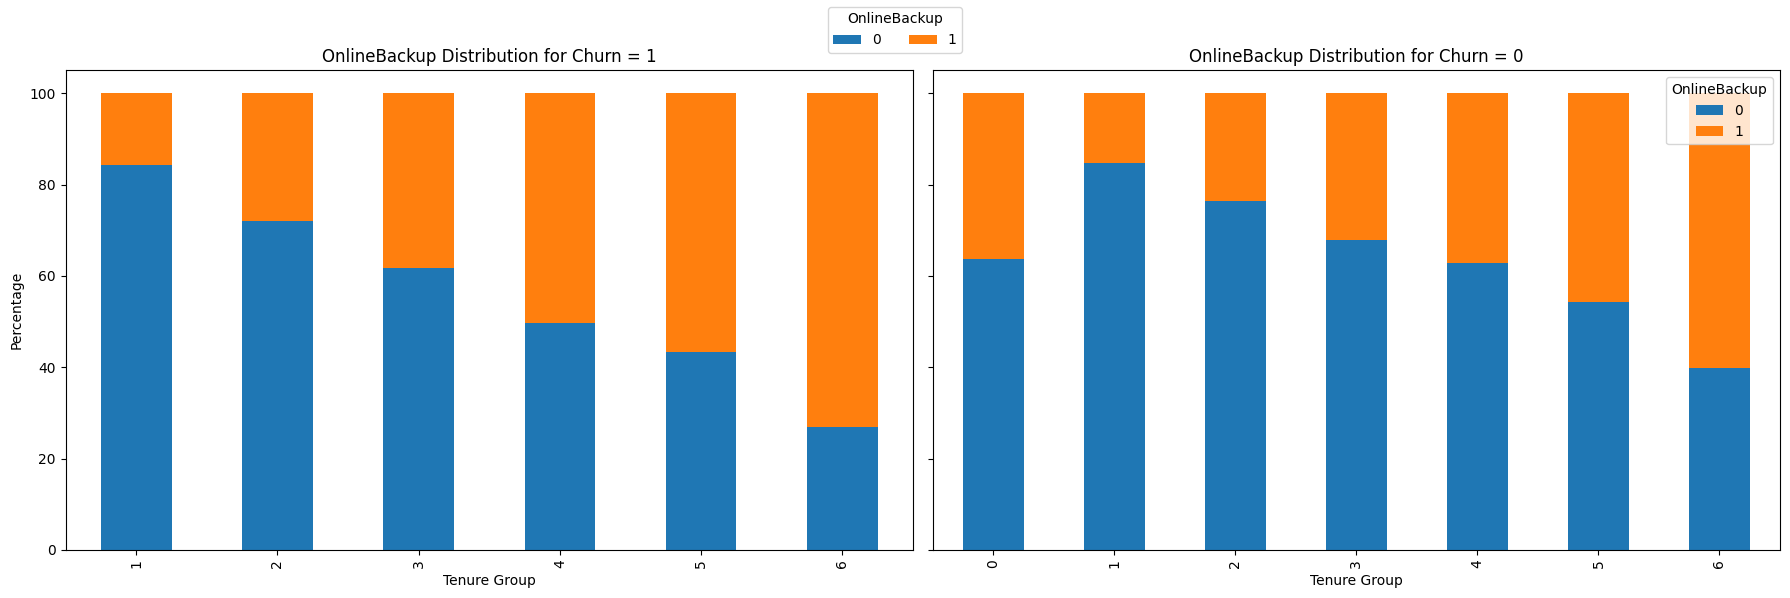

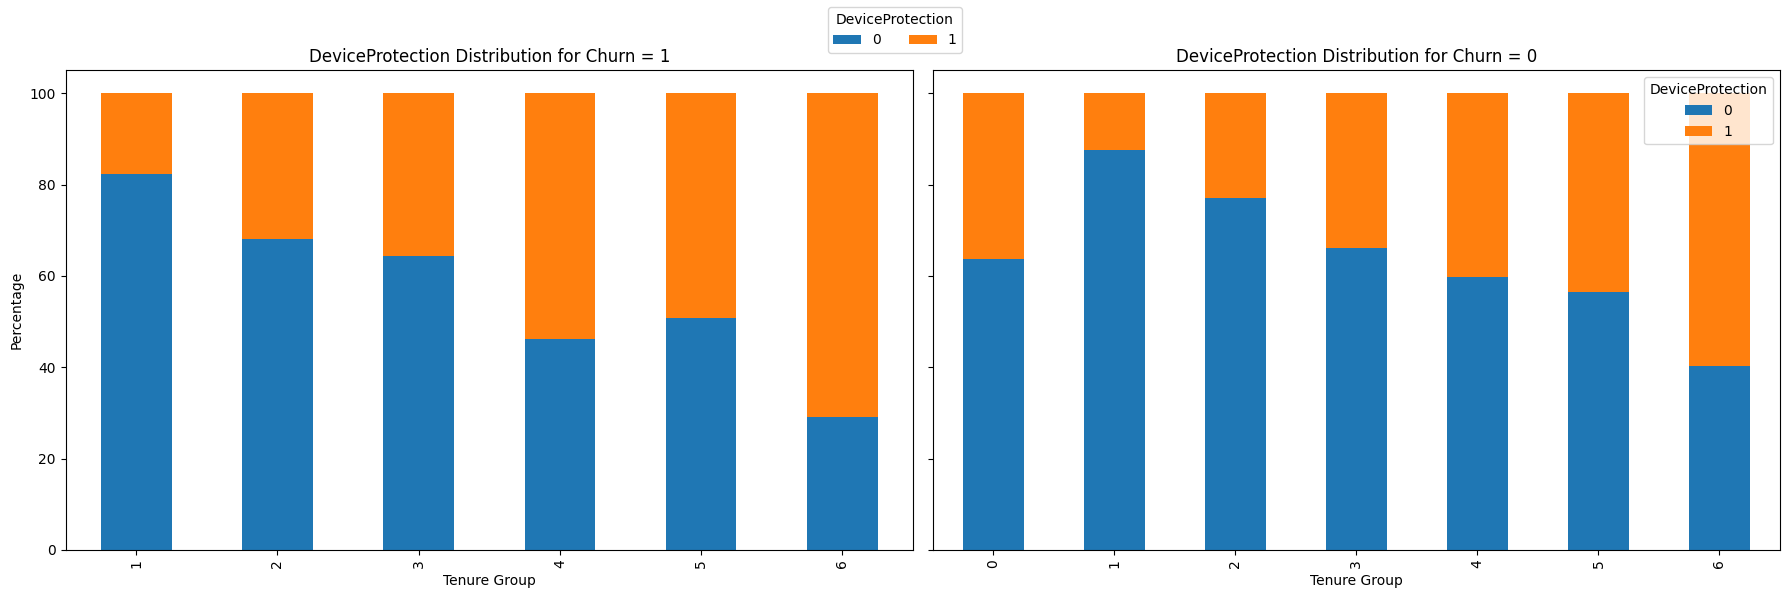

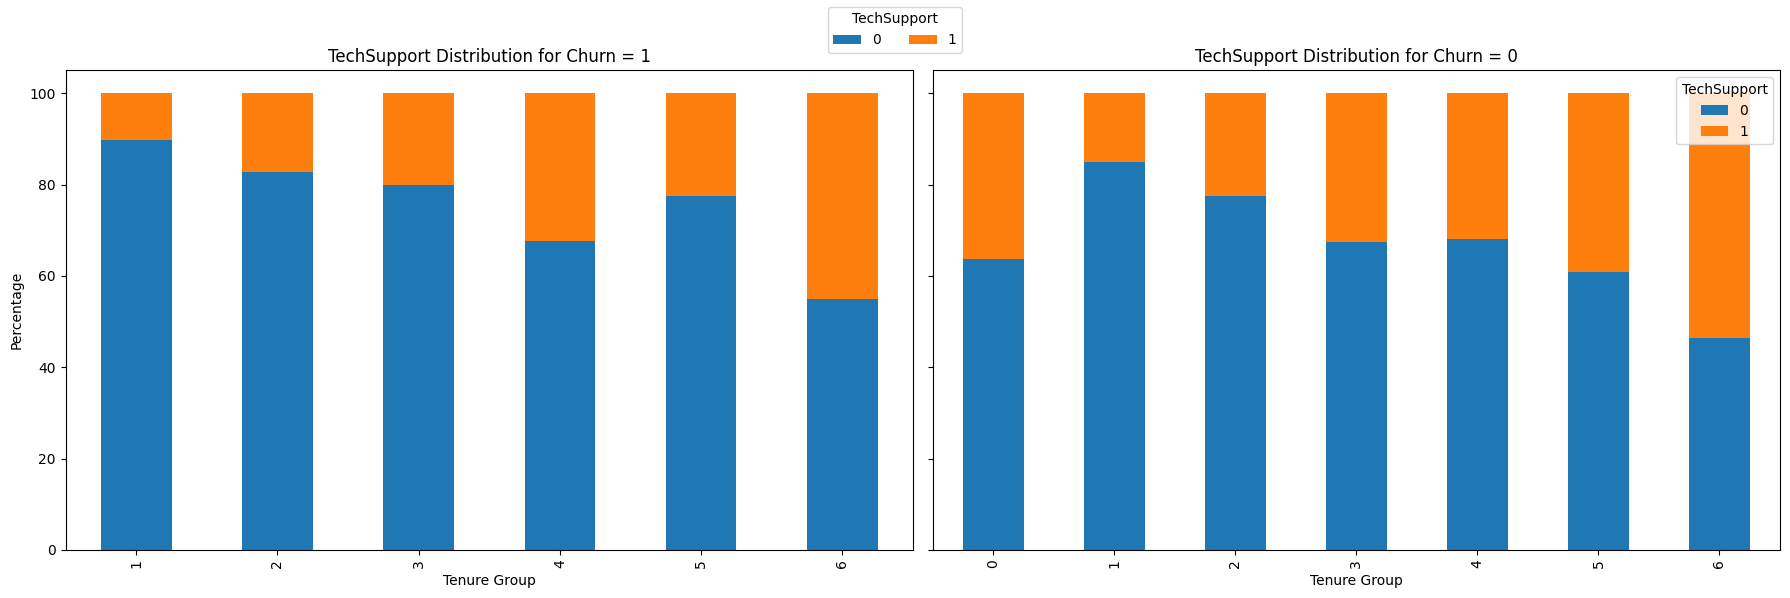

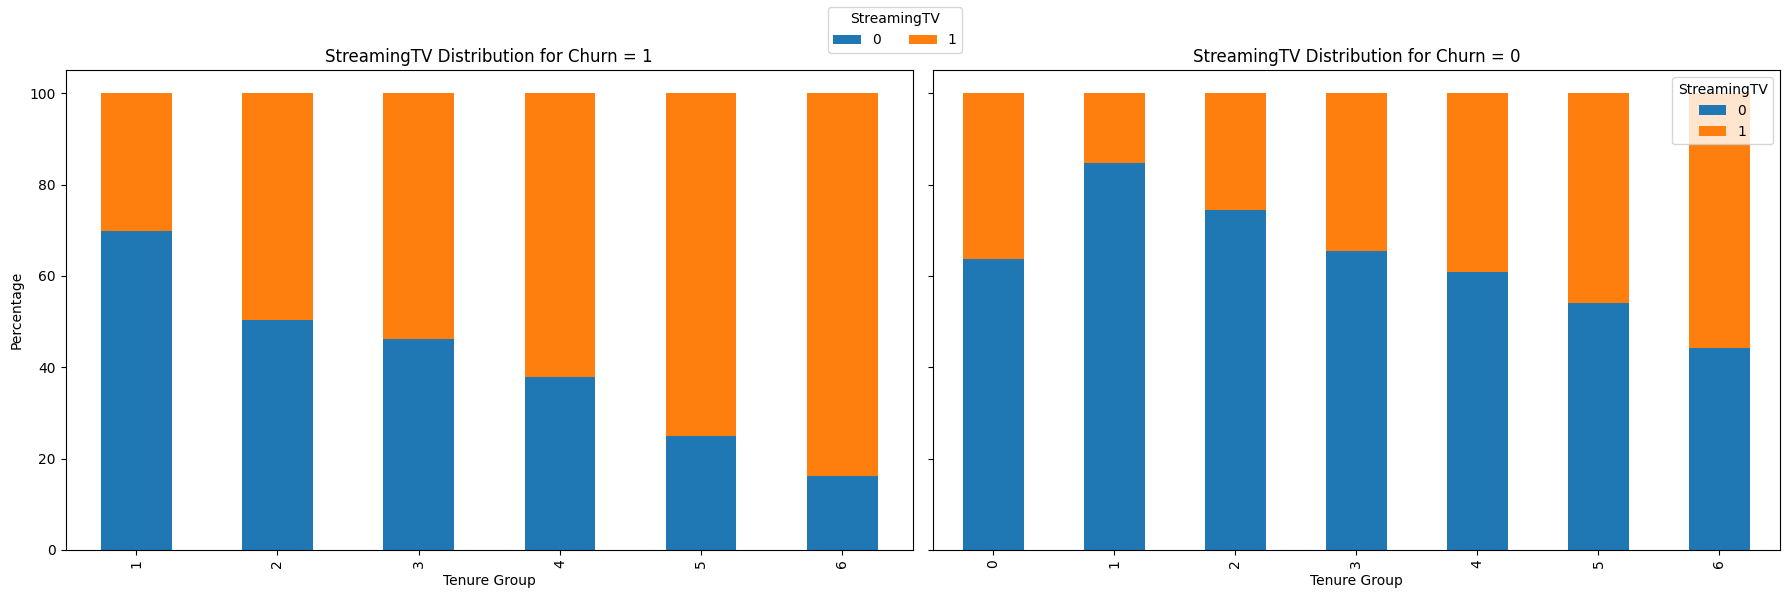

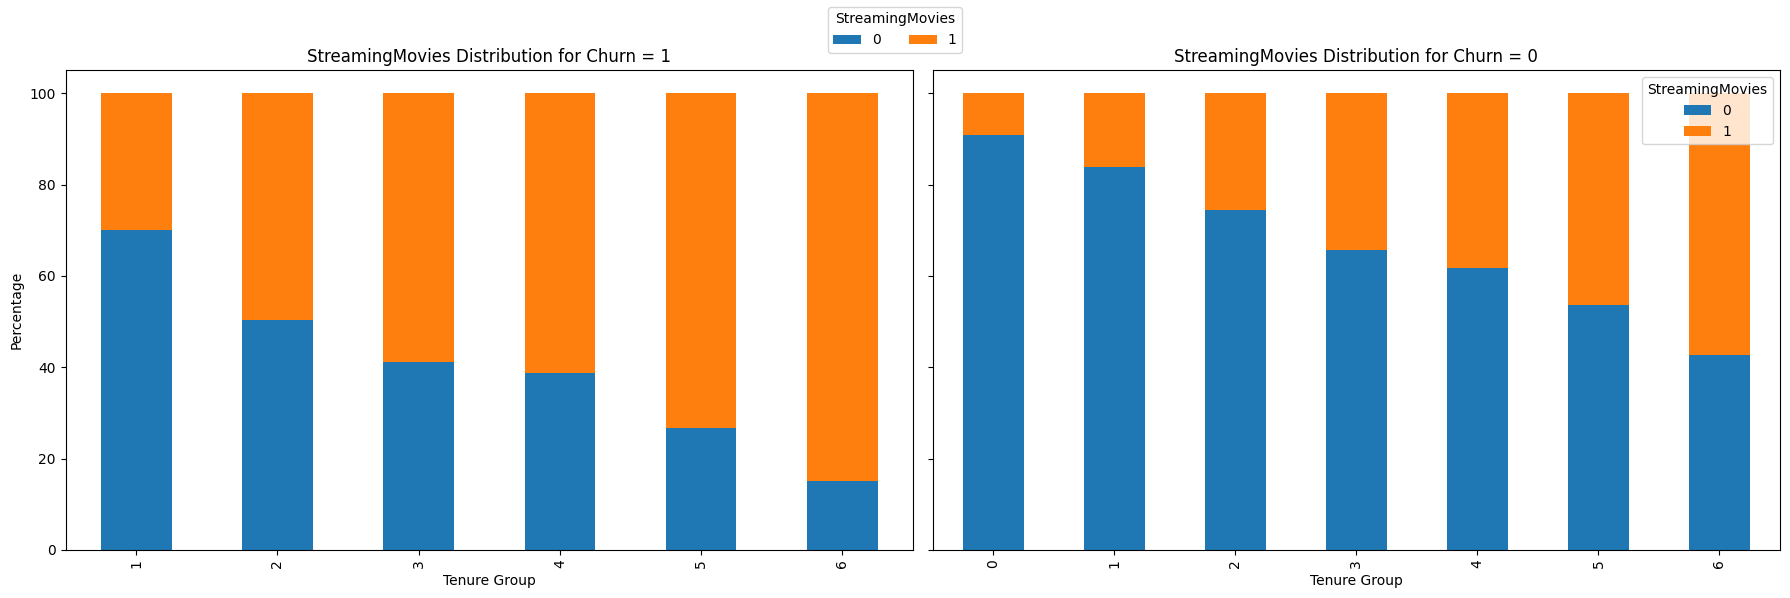

In [10]:
for service in service_columns:
    # 그룹화 및 비율 계산
    service_out_debug = df[df['Churn'] == 1].groupby(['Tenure', service]).size().unstack(fill_value=0)
    service_in_debug = df[df['Churn'] == 0].groupby(['Tenure', service]).size().unstack(fill_value=0)
    service_out_percentage = service_out_debug.div(service_out_debug.sum(axis=1), axis=0).fillna(0) * 100
    service_in_percentage = service_in_debug.div(service_in_debug.sum(axis=1), axis=0).fillna(0) * 100
    
    # 시각화
    plot_side_by_side_all(
        service_out_percentage, service_in_percentage,
        f"{service} Distribution for Churn = 1",
        f"{service} Distribution for Churn = 0",
        service
    )


##### (1-2) Tenure 그룹화 시사점

- 이탈 그룹(Churn=1)에서는 Fiber optic 의 강점인 속도와 안정성을 기반으로 스트리밍 서비스를 이용하는 비중이 높았다.

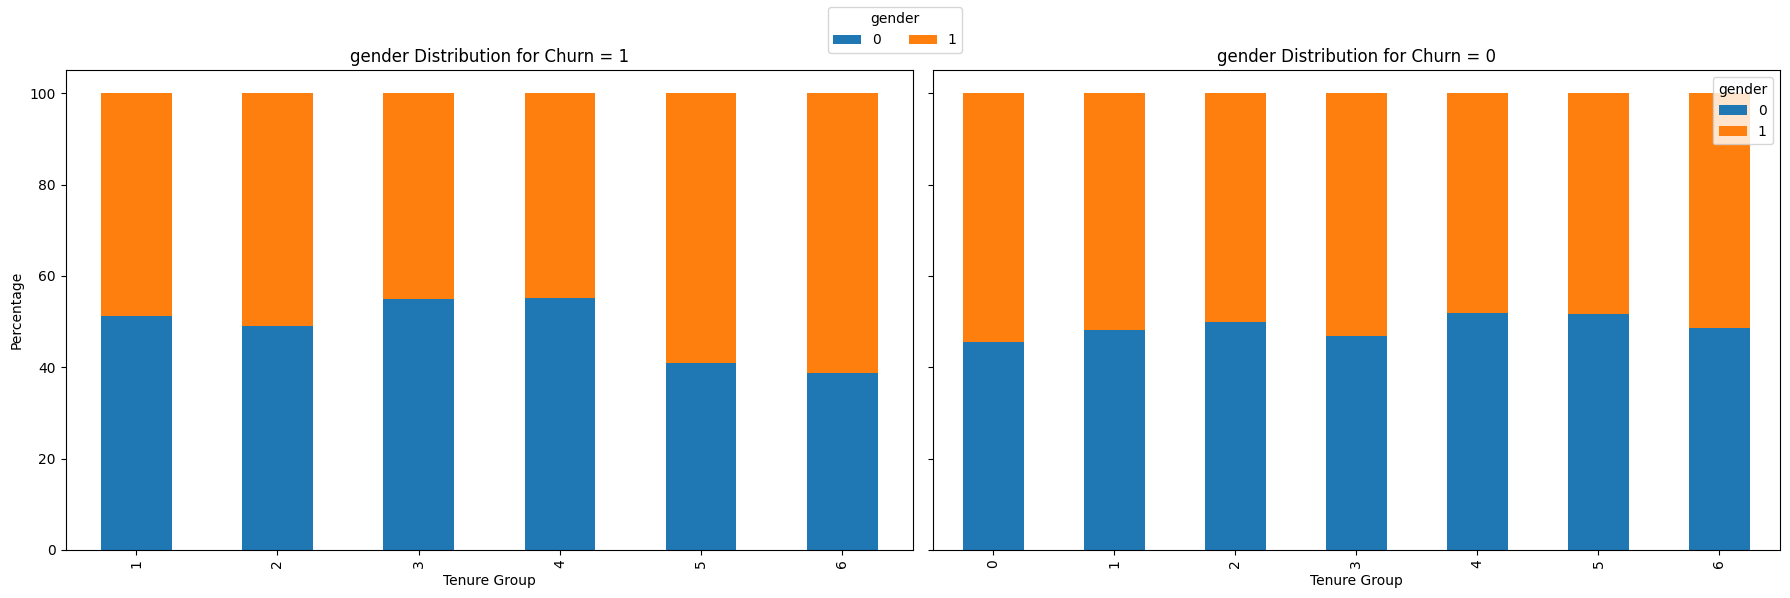

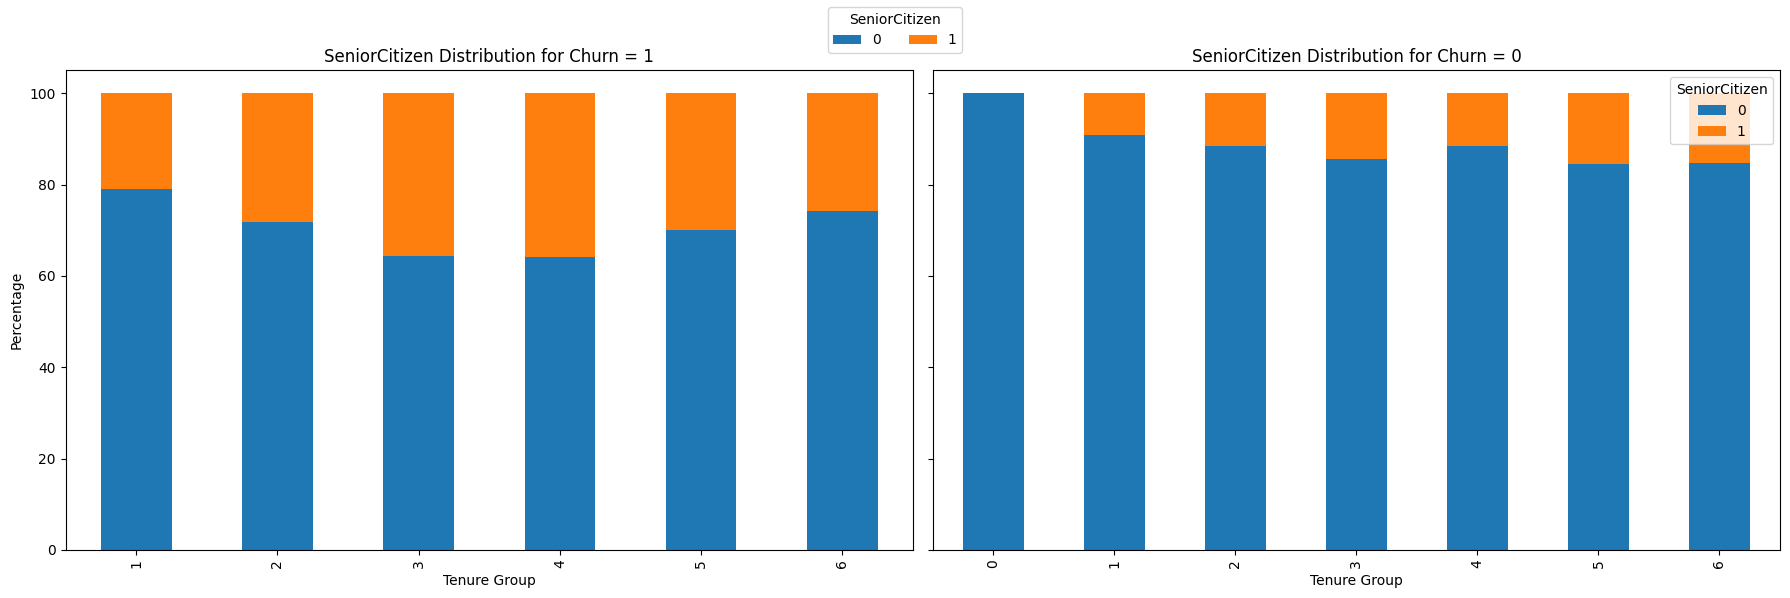

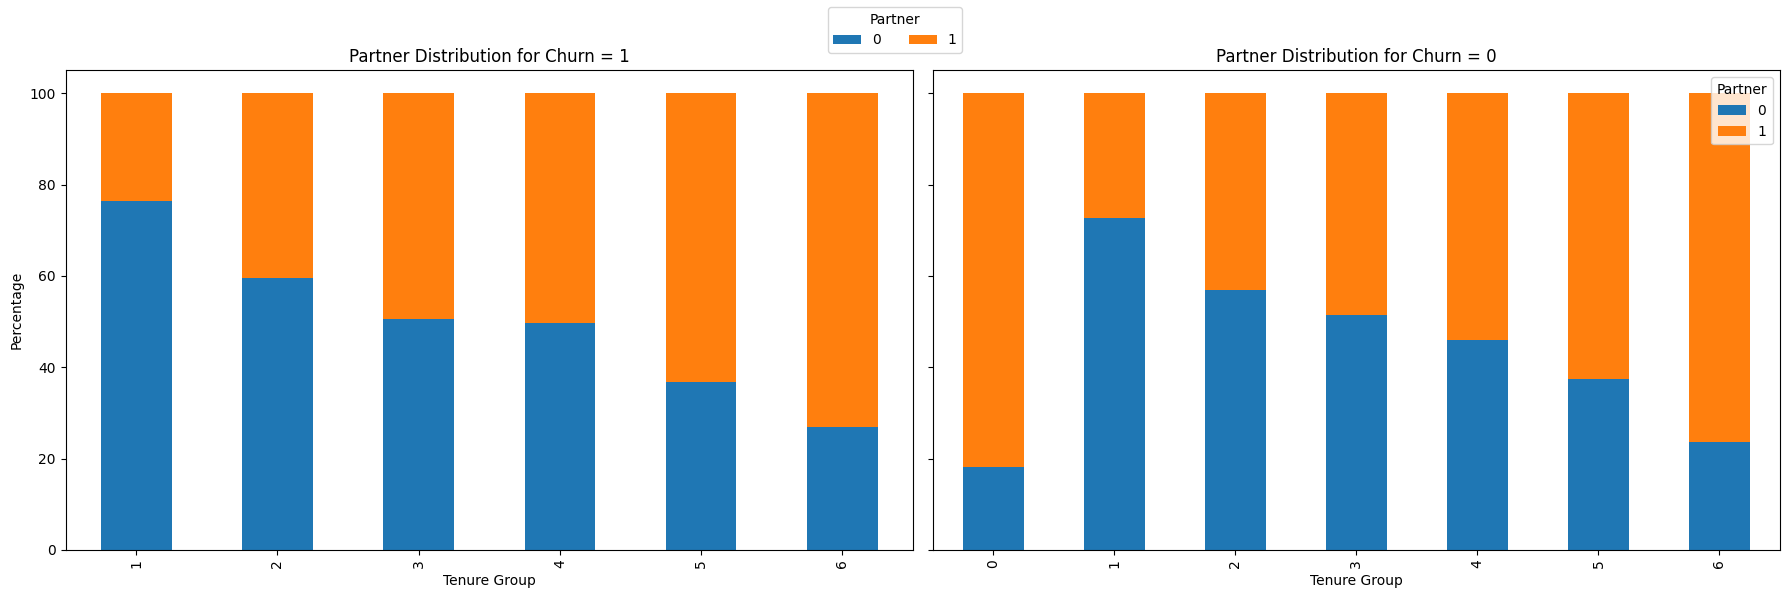

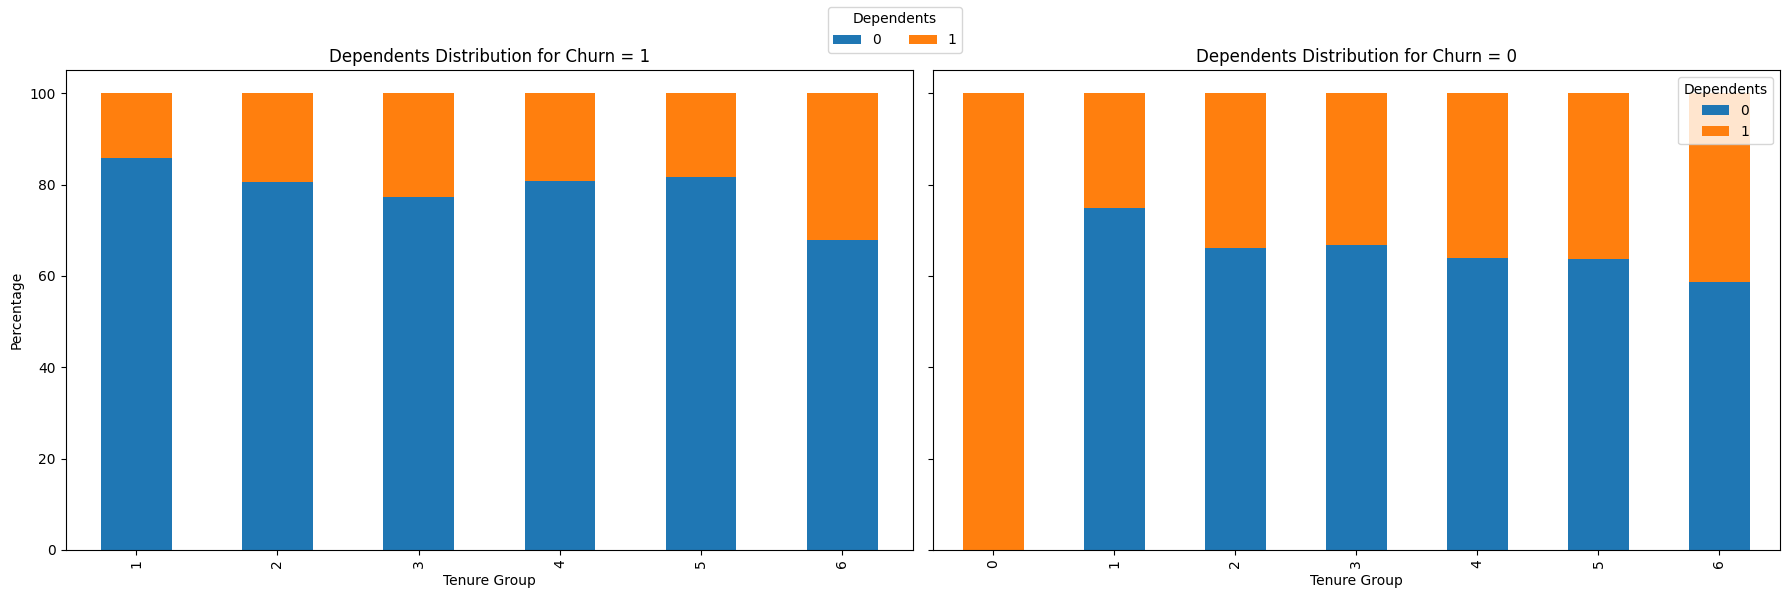

In [11]:
for people in people_columns:
    # 그룹화 및 비율 계산
    people_out_debug = df[df['Churn'] == 1].groupby(['Tenure', people]).size().unstack(fill_value=0)
    people_in_debug = df[df['Churn'] == 0].groupby(['Tenure', people]).size().unstack(fill_value=0)
    people_out_percentage = people_out_debug.div(people_out_debug.sum(axis=1), axis=0).fillna(0) * 100
    people_in_percentage = people_in_debug.div(people_in_debug.sum(axis=1), axis=0).fillna(0) * 100
    
    # 시각화
    plot_side_by_side_all(
        people_out_percentage, people_in_percentage,
        f"{people} Distribution for Churn = 1",
        f"{people} Distribution for Churn = 0",
        people
    )

##### (1-3) Tenure 그룹화 시사점

- 'SeniorCitizen', 'Dependents' 요소와 이탈 여부(Churn=1)가 상관관계가 있을 수 있다.

/tmp/ipykernel_1412225/2130234678.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Contract', y='MonthlyCharges', palette='Set2', inner='quartile')


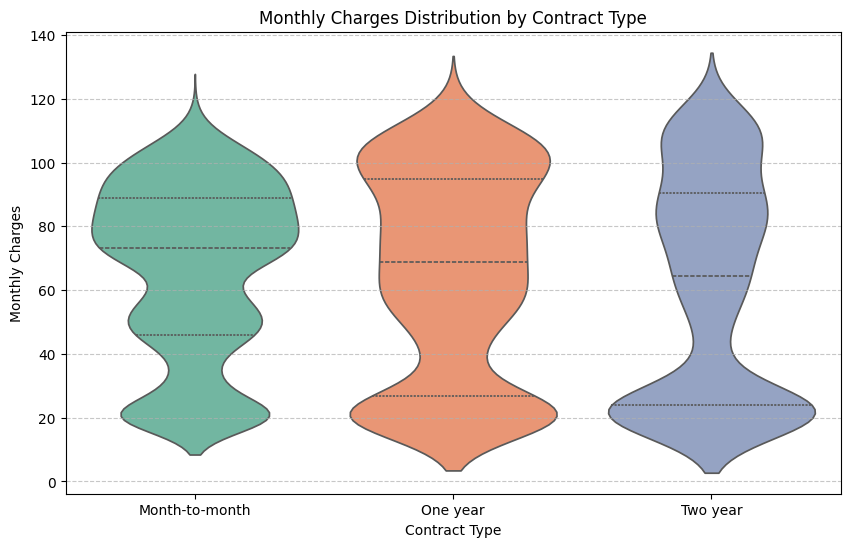

In [12]:
# 가입 조건별 월 이용 금액 분포 시각화
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Contract', y='MonthlyCharges', palette='Set2', inner='quartile')
plt.title('Monthly Charges Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Monthly Charges')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

특정 계약 유형에 따라 월 요금 분포가 다르다면, 구간을 다르게 정의하는 것이 더 합리적일 수 있습니다. 각 계약 유형의 데이터 분포를 반영한 구간 설정은 계약 유형별 세부 분석에 적합합니다. 서로 다른 조건으로 구간을 나누는 것이 문제로 이어질 수 있는 경우는 모든 계약 유형을 같은 기준으로 비교하려는 경우입니다. 예를 들어, 계약 유형을 무시하고 요금 레벨(Level)을 기준으로 전반적인 요금 분포를 비교하려는 경우: 같은 Level 2라도 Month-to-month의 Level 2는 36 ~ 61이지만, Two year의 Level 2는 40 ~ 80으로 정의됩니다. 이는 Level 기준으로 비교할 때 혼란을 초래할 수 있습니다.

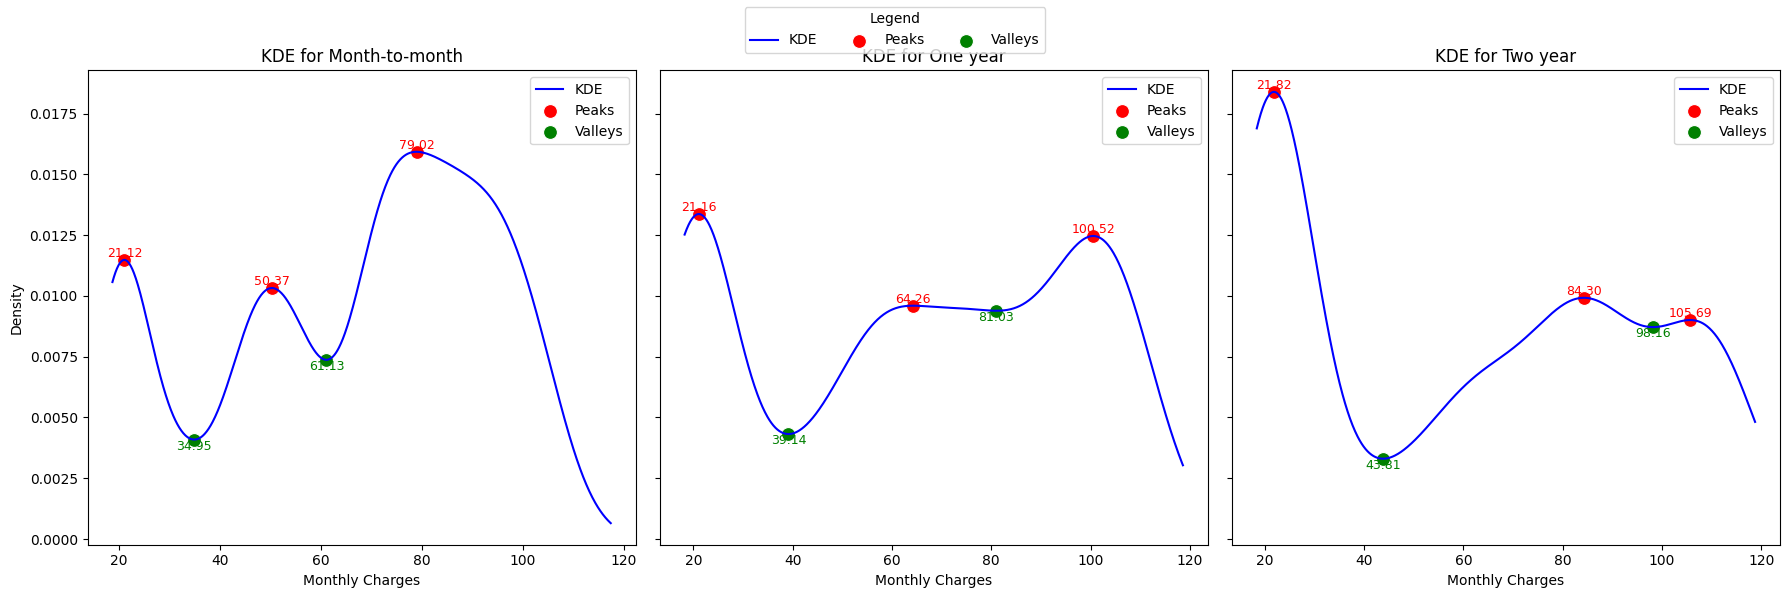

In [13]:
# KDE와 peak 및 valley 계산 및 시각화
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

# 계약 조건별 KDE 및 Peaks/Valleys 시각화를 한 번에 보여주는 코드
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

contract_types = ['Month-to-month', 'One year', 'Two year']

for idx, contract_type in enumerate(contract_types):
    # 데이터 필터링
    data = df[df['Contract'] == contract_type]['MonthlyCharges']
    
    # KDE 계산
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 1000)
    kde_values = kde(x)

    # Find peaks (local maxima)
    peaks, _ = find_peaks(kde_values)
    breakpoints = x[peaks]  # x-coordinates of peaks

    # Find valleys (local minima)
    inverted_kde_values = -kde_values  # Invert KDE values
    valleys, _ = find_peaks(inverted_kde_values)
    valley_points = x[valleys]  # x-coordinates of valleys

    # Plot KDE with peaks and valleys
    sns.lineplot(x=x, y=kde_values, ax=axes[idx], label='KDE', color='blue')
    sns.scatterplot(x=breakpoints, y=kde(breakpoints), ax=axes[idx], color='red', label='Peaks', s=100)
    sns.scatterplot(x=valley_points, y=kde(valley_points), ax=axes[idx], color='green', label='Valleys', s=100)

    # Annotate peaks and valleys
    for bp in breakpoints:
        axes[idx].text(bp, kde(bp), f'{bp:.2f}', color='red', ha='center', va='bottom', fontsize=9)
    for vp in valley_points:
        axes[idx].text(vp, kde(vp), f'{vp:.2f}', color='green', ha='center', va='top', fontsize=9)

    # Plot details
    axes[idx].set_title(f"KDE for {contract_type}")
    axes[idx].set_xlabel("Monthly Charges")
    axes[idx].set_ylabel("Density")

# Add a global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), title='Legend')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [14]:
# 가입 조건별 레벨 설정 함수
def assign_level(contract_type, charge):
    if contract_type == 'Month-to-month':
        if charge <= 35:
            return 1
        elif charge <= 61:
            return 2
        else:
            return 3
    elif contract_type == 'One year':
        if charge <= 39:
            return 1
        elif charge <= 81: 
            return 2
        else:
            return 3
    elif contract_type == 'Two year':
        if charge <= 44:
            return 1
        elif charge <= 98:
            return 2
        else:
            return 3

# 레벨 추가
df['CustomerLevel'] = df.apply(lambda x: assign_level(x['Contract'], x['MonthlyCharges']), axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,Churn,Tenure,CustomerLevel
0,0,0,1,0,0,0,DSL,0,1,0,0,0,0,Month-to-month,Electronic check,29.85,0,1,1
1,1,0,0,0,1,0,DSL,1,0,1,0,0,0,One year,Mailed check,56.95,0,3,2
2,1,0,0,0,1,0,DSL,1,1,0,0,0,0,Month-to-month,Mailed check,53.85,1,1,2
3,1,0,0,0,0,0,DSL,1,0,1,1,0,0,One year,Bank transfer (automatic),42.30,0,4,2
4,0,0,0,0,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,Electronic check,70.70,1,1,3


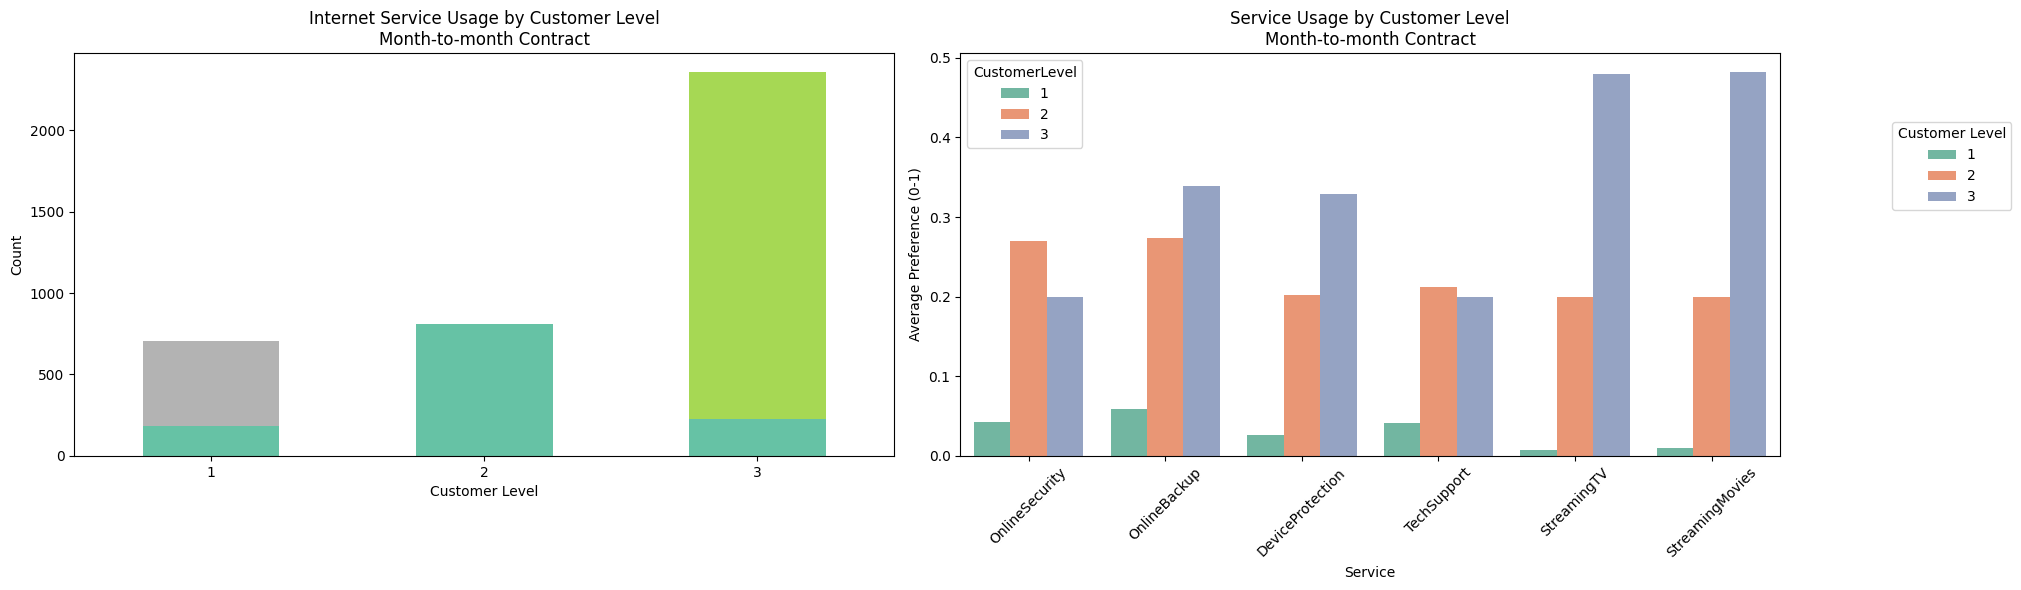

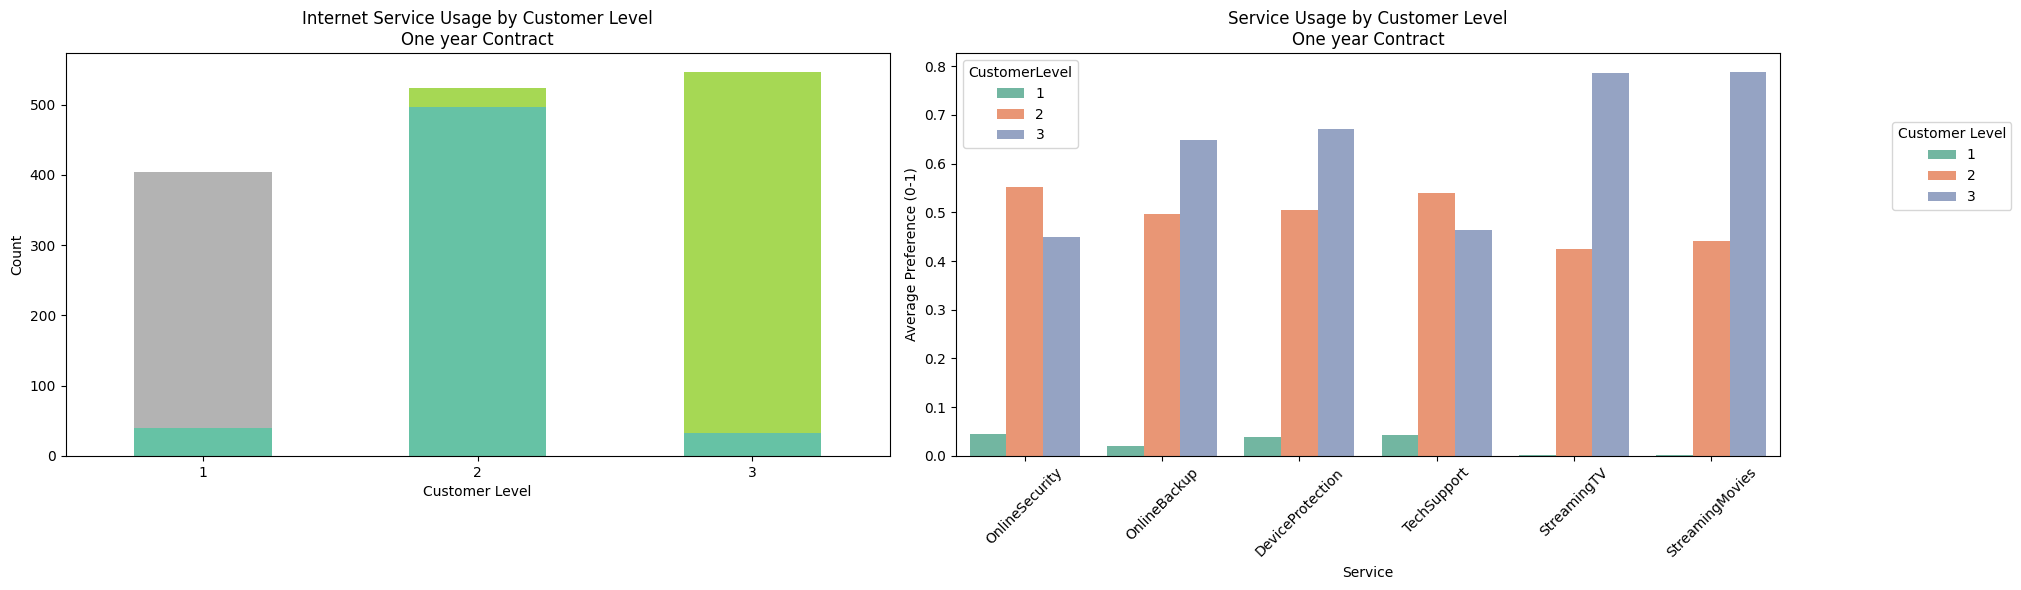

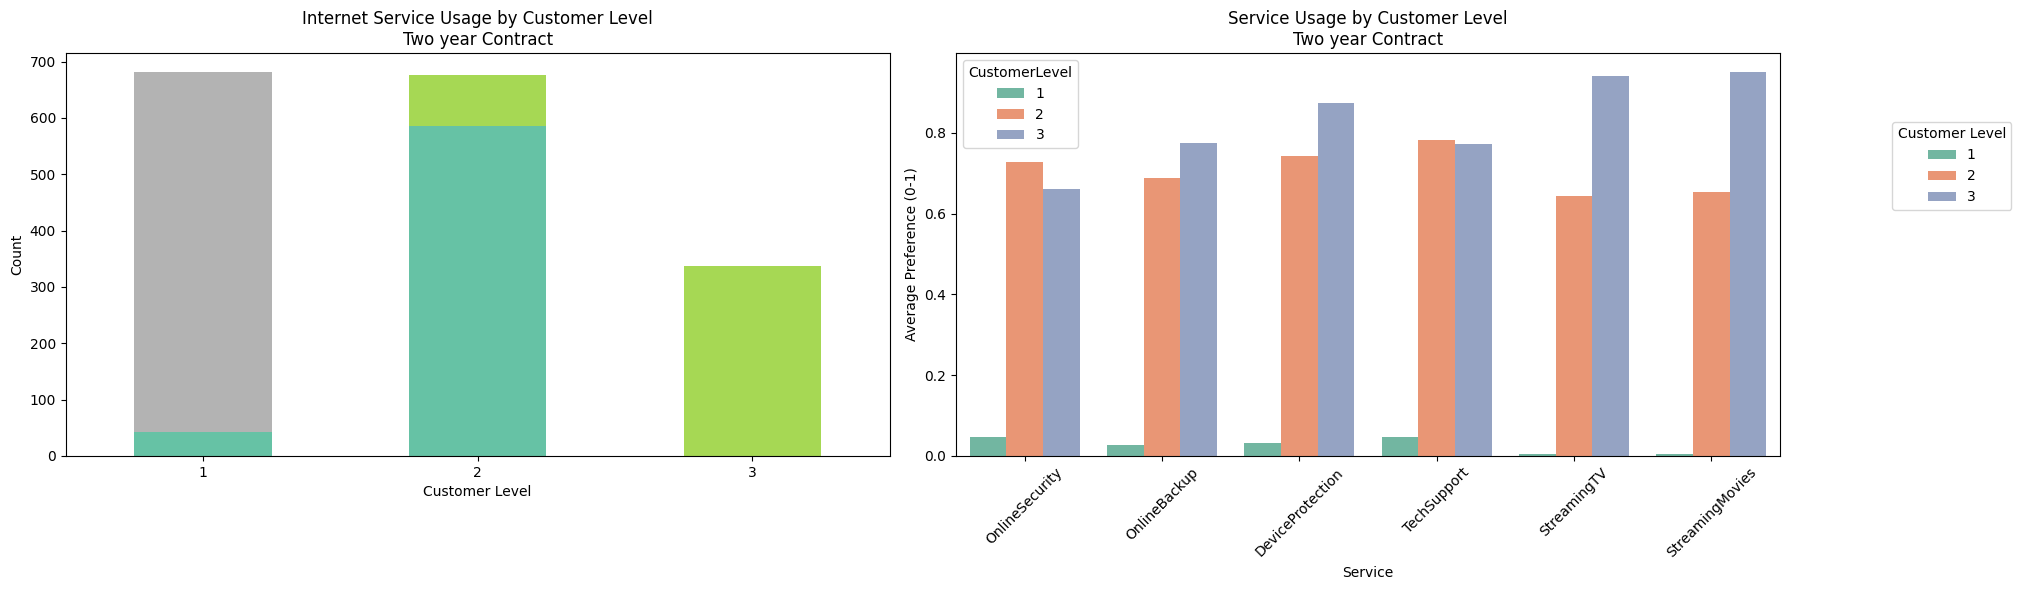

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가입 조건별 소비자 레벨에 따른 인터넷 서비스와 기타 서비스 시각화를 생성하는 함수
def plot_service_and_internet_by_level(data, contract_type):
    # 해당 계약 조건의 데이터 필터링
    filtered_data = data[data['Contract'] == contract_type]
    
    # 인터넷 서비스 분포
    internet_service_usage = filtered_data.groupby(['CustomerLevel', 'InternetService']).size().unstack(fill_value=0)
    
    # 서비스 이용 비율 계산
    service_usage = filtered_data.groupby('CustomerLevel')[service_columns].mean().reset_index()
    
    # 서비스를 long-form으로 변환
    service_usage_long = service_usage.melt(id_vars=['CustomerLevel'], var_name='Service', value_name='Average Preference')
    
    # 서브플롯 생성: 1행 2열
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # 인터넷 서비스 그래프 (왼쪽 서브플롯)
    internet_service_usage.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2', legend=False)
    axes[0].set_title(f'Internet Service Usage by Customer Level\n{contract_type} Contract')
    axes[0].set_xlabel('Customer Level')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=0)
    
    # 서비스 이용 Barplot (오른쪽 서브플롯)
    sns.barplot(
        data=service_usage_long,
        x='Service',
        y='Average Preference',
        hue='CustomerLevel',
        palette='Set2',
        ax=axes[1]
    )
    axes[1].set_title(f'Service Usage by Customer Level\n{contract_type} Contract')
    axes[1].set_xlabel('Service')
    axes[1].set_ylabel('Average Preference (0-1)')
    axes[1].tick_params(axis='x', rotation=45)
    
    # 범례 조정
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(
        handles, labels, title='Customer Level', bbox_to_anchor=(1.05, 0.8), loc='upper left'
    )
    
    plt.tight_layout()
    plt.show()

# 각 계약 조건별로 시각화 생성
contracts = df['Contract'].unique()
for contract in contracts:
    plot_service_and_internet_by_level(df, contract)


##### (2-1) Customer Level 그룹화 시사점

- Month-to-month 계약
  - Level 1 사용자는 인터넷 서비스를 사용하지 않는 자가 대부분이었고, 인터넷 서비스를 사용하는 자는 스트리밍 서비스에 대해 낮은 선호를 보였다.
  - Level 2 사용자는 전부 DSL 사용자였으며 Online Security, Online Backup에 대해 스트리밍 서비스보다 다소 높은 선호를 보였다. 
  - Level 3 사용자는 Fiber optic을 사용하는 비중이 높았으며 이들은 스트리밍 서비스에 높은 선호를 보였다.

- One year 계약
  - Level 1 사용자는 인터넷 서비스를 사용하지 않는 자가 대부분이었고, 인터넷 서비스를 사용하는 자는 스트리밍 서비스에 대해 낮은 선호를 보였다.
  - Level 2 사용자는 대부분 DSL 사용자였으며 온라인 기술 지원, 보안, 백업, 기기 보호에 대해 스트리밍 서비스보다 다소 높은 선호를 보였다.
  - Level 3 사용자는 Fiber optic을 사용하는 비중이 높았으며 이들은 스트리밍 서비스에 높은 선호를 보였다.

- Two year 계약
  - Level 1 사용자는 인터넷 서비스를 사용하지 않는 자가 대부분이었고, 인터넷 서비스를 사용하는 자는 스트리밍 서비스에 대해 낮은 선호를 보였다.
  - Level 2 사용자는 대부분 DSL 사용자였으며 온라인 기술 지원, 보안, 백업, 기기 보호에 대해 스트리밍 서비스보다 높은 선호를 보였다.
  - Level 3 사용자는 전부 Fiber optic 사용자였으며 스트리밍 서비스에 높은 선호를 보였다.

#### 1.3 가설

- Fiber optic을 사용하고 Paperless Billing 서비스를 이용하는 집단은 어떤 모종의 이유로 이탈한다. 
- Month-to-month 계약에서는 Fiber optic 사용자 비중이 매우 높고, One year 계약에서는 DSL 사용자와 Fiber optic 사용자 비중이 비슷하며, Two year 계약에서는 DSL 사용자 비중이 FIber optic 사용자 비중보다 높다. 또한 인터넷 서비스를 이용하지 않는 가입자는 Month-to-month, One year, Two year 순서로 증가했다. 계약 유형에 따라 인터넷 서비스 이용에 대한 민감도가 다르거나, 가입 시기가 오래될 수록 인터넷 서비스를 구식으로 이용하는 것으로 보인다.
- Fiber optic 서비스 사용자는 스트리밍 서비스를 애용한다.
- SeniorCitizen, Dependents가 이탈에 영향을 주는 인구통계학 적 요소로 보인다. 

### 2. 가설 검정

#### 2.1 상관계수 히트맵

corr 히트맵을 이용하여 제기한 가설 속 요소 간 상관관계를 검증해본다.

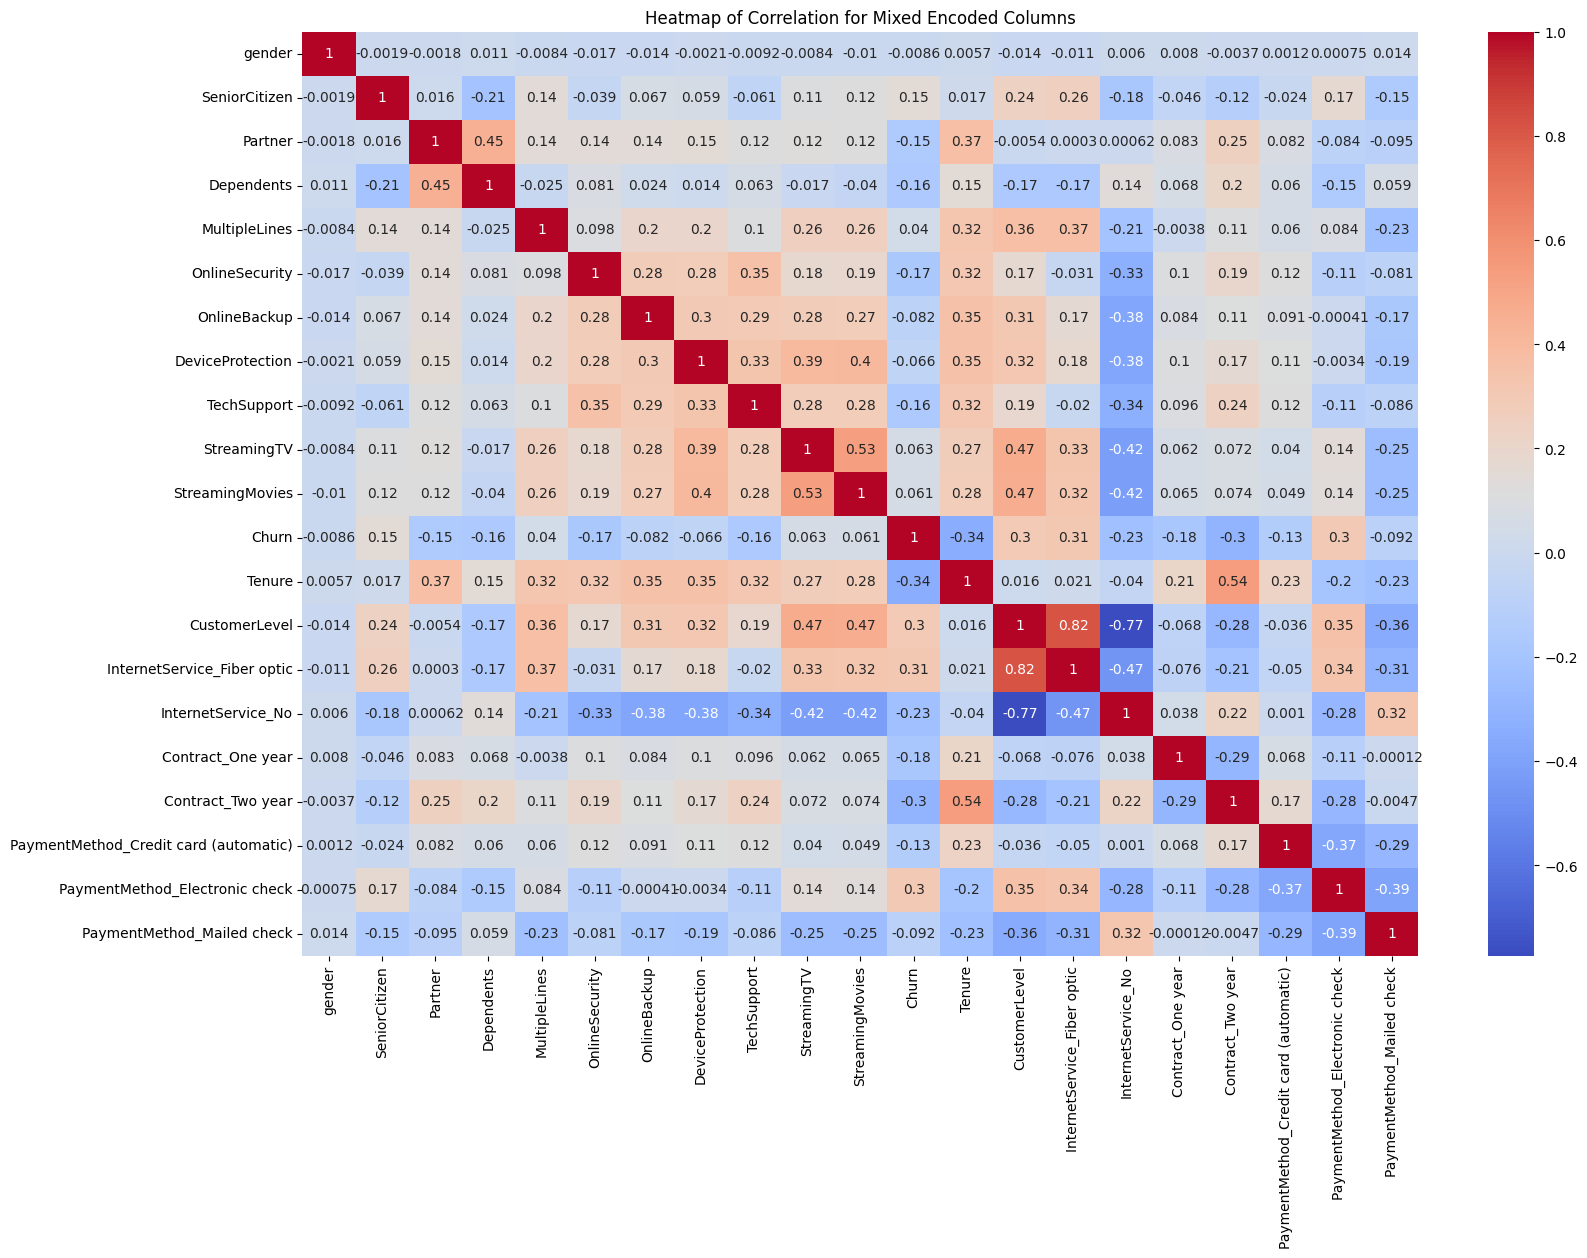

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df = df.drop(['MonthlyCharges', 'PhoneService'], axis=1)

# Initialize encoders
label_encoder = LabelEncoder()
# Correct initialization of OneHotEncoder with sparse_output
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap

# Label encoding for CustomerLevel (ordinal relationship)
df_encoded = df.copy()
df_encoded['CustomerLevel'] = label_encoder.fit_transform(df_encoded['CustomerLevel'])

# One-hot encoding for remaining categorical columns
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']
one_hot_encoded = pd.DataFrame(
    one_hot_encoder.fit_transform(df_encoded[categorical_cols]),
    columns=one_hot_encoder.get_feature_names_out(categorical_cols)
)

# Merge one-hot encoded data back to the dataframe
df_encoded = pd.concat([df_encoded, one_hot_encoded], axis=1)
df_encoded = df_encoded.drop(categorical_cols, axis=1)

# Compute correlation matrix
correlation_matrix = df_encoded.corr()

# Plot Heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title("Heatmap of Correlation for Mixed Encoded Columns")
plt.show()

##### (1) 상관계수 히트맵 시사점

- 관찰한 대로 소비 수준은 사용하는 인터넷 서비스 종류와 밀접한 관련이 있다.
- SeniorCitizen, Dependents는 이탈(Churn)이나 유지기간(Tenure)에 별 영향을 미치지 않지만 Partner는 유지기간(Tenure)에 약간의 영향을 미친다.
- 스트리밍 서비스에 미치는 영향은 InternetService_Fiber optic보다 Customer Level이 더 높게 나왔다.
- Customer Level에 미치는 영향은 InternetService가 스트리밍 서비스보다 높게 나왔다. 
- Two year 계약 유형이 Tenure와 다소 높은 상관관계가 있는 것으로 나왔다.

In [17]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df_encoded):
    vif_data = pd.DataFrame()
    vif_data["variable"] = df_encoded.columns
    vif_data["VIF"] = [variance_inflation_factor(df_encoded.values, i) for i in range(df_encoded.shape[1])]
    return vif_data

numeric_df = df_encoded.select_dtypes(include=np.number).dropna()
vif = calculate_vif(numeric_df)
vif

,variable,VIF
0,gender,1.947243
1,SeniorCitizen,1.367037
2,Partner,2.804591
3,Dependents,1.966111
4,MultipleLines,2.322469
5,OnlineSecurity,1.989351
6,OnlineBackup,2.109175
7,DeviceProtection,2.256409
8,TechSupport,2.102832
9,StreamingTV,2.680418


##### (2) 다중공선성 문제

- VIF는 선형 회귀와 같은 선형 모델에서 중요한 지표이다. 선형 모델은 변수 간 강한 상관 관계가 있으면 회귀 계수의 불안정성과 해석 가능성에 부정적인 영향을 미친다. 각 계약 유형에서 소비 수준에 따라 지정한 CustomerLevel이 16.2로 다중공선성 문제를 내포하고 있다. 

- 그러나 트리 기반 모델(예: 랜덤 포레스트, 결정 트리, XGBoost, LightGBM)에서는 **VIF(Variance Inflation Factor)** 가 크게 중요하지 않다. 트리 기반 모델은 분산 분할(Feature Splitting) 방식을 사용한다. 즉, 입력 변수 간의 상관 관계(다중공선성)가 있더라도 모델은 중요한 변수들을 분할 기준으로 선택하고, 상관성이 높은 다른 변수들을 무시하거나 분할하지 않는다.

### 3. Train / Test 세트 분리 및 클래스 불균형 해소

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. 데이터 준비
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 4. StratifiedKFold와 앙상블을 이용한 예측 및 성능 평가

In [20]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=1)

# Stratified KFold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results
all_ensemble_probs = []
all_y_true = []

print("\nStratified KFold Evaluation:")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_smote, y_train_smote), 1):
    # Split data for this fold
    X_train_fold, X_val_fold = X_train_smote.iloc[train_idx], X_train_smote.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]
    
    # Train models
    rf_model.fit(X_train_fold, y_train_fold)
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities
    rf_probs = rf_model.predict_proba(X_val_fold)[:, 1]
    xgb_probs = xgb_model.predict_proba(X_val_fold)[:, 1]
    
    # Soft Voting: average probabilities
    ensemble_probs = (rf_probs + xgb_probs) / 2
    all_ensemble_probs.extend(ensemble_probs)
    all_y_true.extend(y_val_fold)
    
    # Calculate AUC for this fold
    fold_auc = roc_auc_score(y_val_fold, ensemble_probs)
    print(f"Fold {fold} AUC: {fold_auc:.3f}")

# Overall evaluation
overall_auc = roc_auc_score(all_y_true, all_ensemble_probs)
print(f"\nOverall AUC: {overall_auc:.3f}")

# Optional: Classification report on validation data
ensemble_predictions = (np.array(all_ensemble_probs) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(all_y_true, ensemble_predictions))


Stratified KFold Evaluation:


/home/dev-hammy/pj/tele-churn/tele/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.904


/home/dev-hammy/pj/tele-churn/tele/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.898


/home/dev-hammy/pj/tele-churn/tele/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.915


/home/dev-hammy/pj/tele-churn/tele/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:10:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.918
Fold 5 AUC: 0.907

Overall AUC: 0.908

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      4139
           1       0.81      0.87      0.84      4139

    accuracy                           0.83      8278
   macro avg       0.83      0.83      0.83      8278
weighted avg       0.83      0.83      0.83      8278



/home/dev-hammy/pj/tele-churn/tele/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:10:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
